In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import corner
import astroquery
import sklearn as skl
import seaborn as sns
import scipy
import statsmodels.api as sm

from skimage import data
from skimage.feature import match_template
from scipy.signal import find_peaks
import math
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Simulate Point Sources

In [3]:
np.random.seed(27)

In [4]:
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')


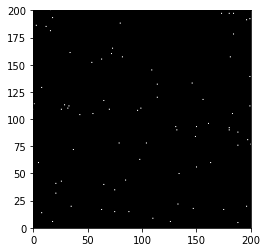

In [5]:
image = np.zeros((500, 500))
simpleRandomPoints = np.array([np.random.rand(500)*500,np.random.rand(500)*500]).T
for point in simpleRandomPoints:
    image[int(point[0]), int(point[1])] = 100

plt.imshow(image,vmin=0,vmax=100,cmap='gray', origin='lower')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

In [ ]:
from scipy.stats import rv_continuous
class flux_distr(rv_continuous):
    "Gaussian distribution"
    def _cdf(self, x):
        return np.where(x < 2, x**(-5/2), x**(-3/2))
    def _rvs(self, size):
        uniformSamples = np.random.rand(size)
        #0.3535 comes from solving the equation for the CDF at x=2
        uniformSamples[uniformSamples>0.3535] = uniformSamples[uniformSamples>0.3535]**(-2/5)
        uniformSamples[uniformSamples<=0.3535] = uniformSamples[uniformSamples<=0.3535]**(-2/3)
        return uniformSamples
    def _pdf(self, x):
        return x**(-5/2)
    def _brokenpdf(self, x):
        return np.where(x <= 2, x**(-7/2), x**(-5/2))
flux_distribution = flux_distr(name='flux_distribution')


In [66]:
simpleRandomPoints
df = pd.DataFrame(simpleRandomPoints.astype(int), columns=['x', 'y'])
df['color'] = np.random.normal(loc=2,scale=0.5,size=len(df))
df['f1'] = flux_distribution._rvs(size=len(df))
df['log_f1'] = np.log(df['f1'])
df['f2'] = df['f1']*np.exp(df['color'])
df['log_f2'] = np.log(df['f2'])
print(df)

       x    y     color        f1    log_f1         f2    log_f2
0    212  414  1.768120  3.700157  1.308375  21.682271  3.076495
1    407  345  2.505662  1.476919  0.389958  18.094718  2.895620
2    367  119  2.280333  1.081699  0.078533  10.578948  2.358866
3    434  266  1.914446  2.860221  1.050899  19.401395  2.965345
4    191  196  1.419462  1.133698  0.125485   4.687721  1.544946
..   ...  ...       ...       ...       ...        ...       ...
495  428  260  2.917779  1.157212  0.146014  21.408612  3.063793
496  215  384  1.656231  1.226948  0.204530   6.428631  1.860762
497  323  441  2.648682  1.000273  0.000272  14.139246  2.648954
498   15   75  2.207764  1.239542  0.214742  11.274072  2.422506
499  256  195  2.526388  3.157193  1.149683  39.490953  3.676072

[500 rows x 7 columns]


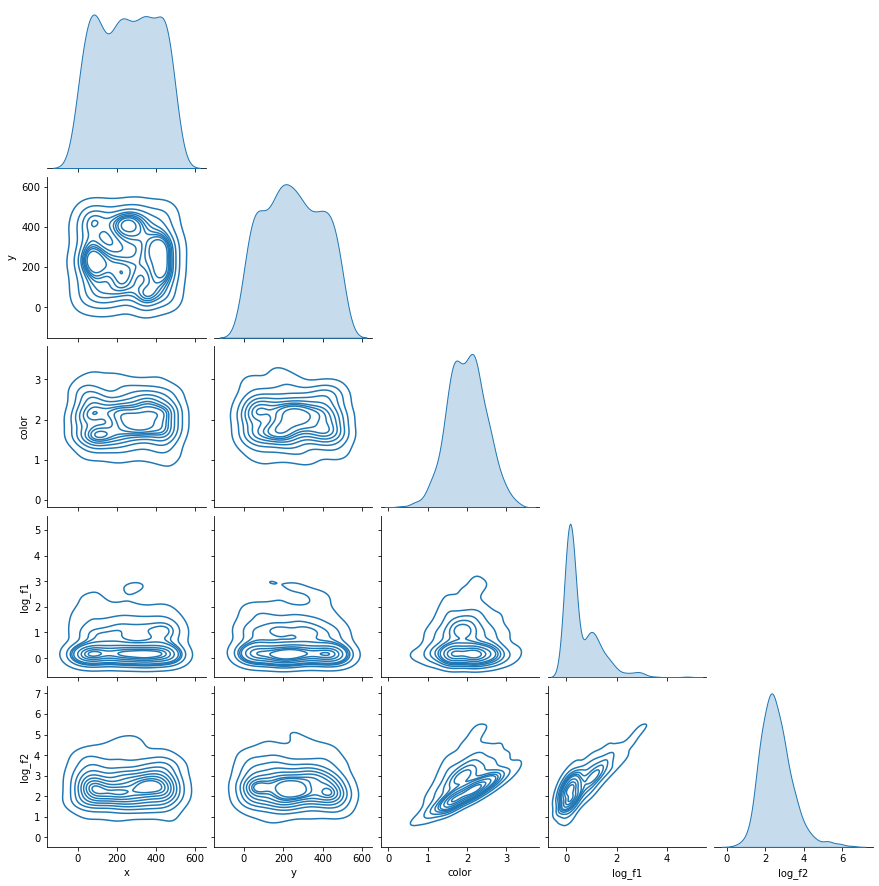

In [67]:
sns.pairplot(data=df, vars=['x', 'y', 'color', 'log_f1','log_f2'],kind='kde',corner=True)
plt.show()

# Simulate Images based on point sources

In [69]:
def gaussian_psf(flux, xcenter, ycenter, size, fwhm=2.5):
    """
    Generates a 2D Gaussian PSF.

    Args:
        size (int): The size of the PSF array.
        fwhm (float): The full width at half maximum of the Gaussian.

    Returns:
        numpy.ndarray: A 2D Gaussian PSF.
    """
    
    x, y = np.indices((size, size))
    
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gaussian = flux*np.exp(-((x - xcenter)**2 + (y - ycenter)**2) / (2 * sigma**2))
    
    return gaussian 

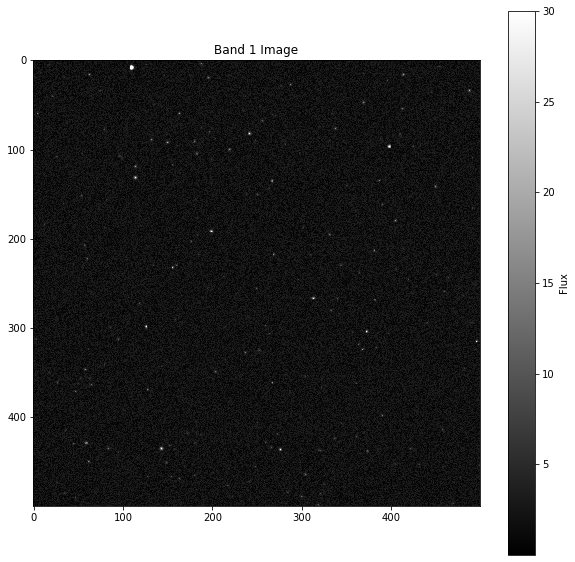

In [70]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f1image = np.zeros((500, 500))
f1imageSignal = np.zeros((500, 500))
f1imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f1image[int(row['x']),int(row['y'])] = np.random.poisson(row['f1'], size=1)
    f1image += gaussian_psf(f1image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f1imageSignal = f1image

noiseLevel = math.ceil(75*np.sum(f1image[~np.isnan(image)])/(500*500))
f1imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f1imageNoise = f1imageNoise.reshape((500, 500))
f1image += f1imageNoise


plt.imshow(f1image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 1 Image")
plt.show()

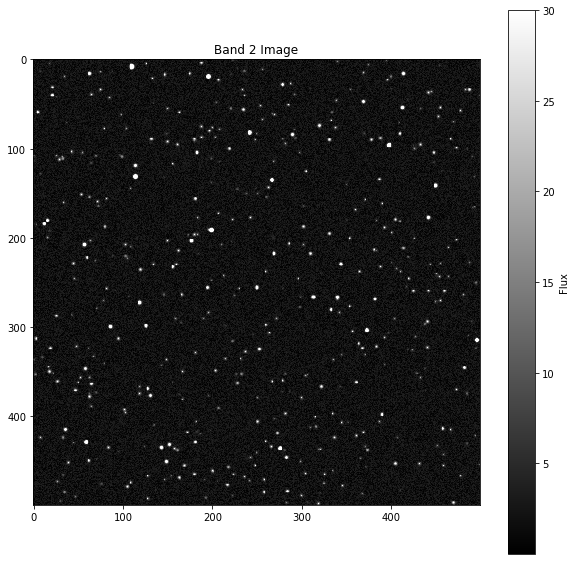

In [71]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f2image = np.zeros((500, 500))
f2imageSignal = np.zeros((500, 500))
f2imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f2image[int(row['x']),int(row['y'])] = np.random.poisson(row['f2'], size=1)
    f2image += gaussian_psf(f2image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f2imageSignal = f2image

#assume that noise is uniform between each band so we can use the same noise level
f2imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f2imageNoise = f2imageNoise.reshape((500, 500))
f2image += f2imageNoise


plt.imshow(f2image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 2 Image")
plt.show()

### Determine Detectable Sources 

Based on our image we want to determine what sources are realistically detectable (with SNR of at least 5). These detectable sources will be considered our true positive when it comes to determining things like specificity. 

In [72]:
TruePositive = []
TruePositiveDF = pd.DataFrame(columns=['x', 'y', 'f1', 'color'])
for index, row in df.iterrows():
    if f1imageSignal[int(row['x']),int(row['y'])]/f1imageNoise[int(row['x']),int(row['y'])] > 5 or f1imageSignal[int(row['x']),int(row['y'])]/f2imageNoise[int(row['x']),int(row['y'])] > 5:
        TruePositive.append([row['x'], row['y'], row['f1'], row['color']])
        TruePositiveDF = TruePositiveDF.append({'x': row['x'], 'y': row['y'], 'f1': row['f1'], 'color': row['color']}, ignore_index=True)
print(len(TruePositive))

228


## Clustering Algorithm 

Use a clustering algorithm to cluster your sources in flux-flux space.

## Spectral Clustering

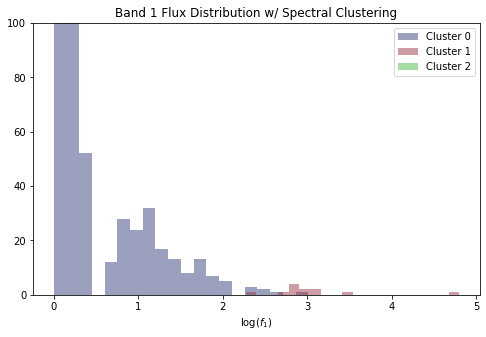

In [96]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
#only cluster based on the log fluxes
tempData = df[['log_f1','log_f2']]
kmeans = SpectralClustering(n_clusters=2).fit(tempData)

df['label'] = kmeans.labels_


fig,ax = plt.subplots(figsize=(8, 5))
colors = [(0.23, 0.26, 0.5),(0.61,0.23,0.29),(0.3,0.73,0.29)]

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f1'], bins=20,color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.legend()
plt.ylim(0,100)
plt.title('Band 1 Flux Distribution w/ Spectral Clustering')
plt.show()

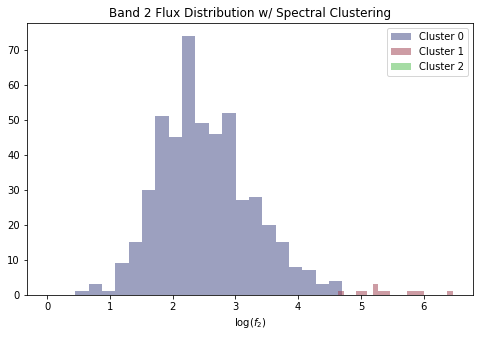

In [97]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f2'],bins=20, color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_2$)')
plt.legend()
plt.title('Band 2 Flux Distribution w/ Spectral Clustering')
plt.show()

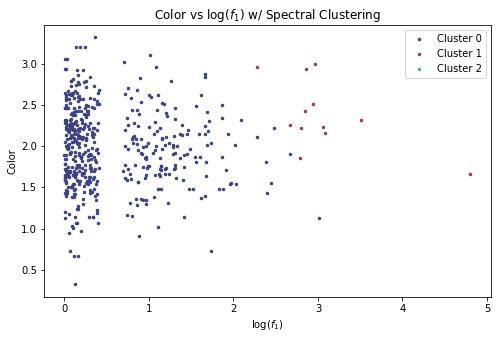

In [98]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.scatter(cluster_data['log_f1'], cluster_data['color'], color=colors[k], marker=".", s=25, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.ylabel('Color')
plt.legend()
plt.title('Color vs log($f_1$) w/ Spectral Clustering')
plt.show()

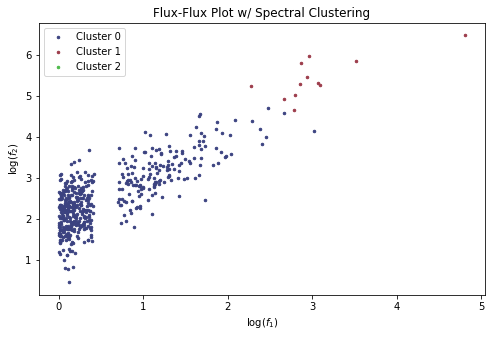

In [99]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.scatter(cluster_data['log_f1'], cluster_data['log_f2'], color=colors[k], marker=".", s=25, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.ylabel('log($f_2$)')
plt.legend()
plt.title('Flux-Flux Plot w/ Spectral Clustering')
plt.show()

In [100]:
df.label.value_counts()

0    488
1     12
Name: label, dtype: int64

## Gaussian Mixture Modeling

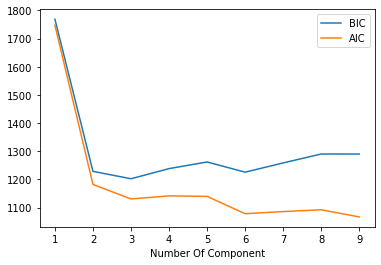

In [80]:
#Prepare
n_component = np.arange(1,10)

tempData = df[['log_f1','log_f2']]
#Create GGM Model
models = [GaussianMixture(n_components = n).fit(tempData) for n in n_component]

plt.plot(n_component,
         [m.bic(tempData) for m in models],
         label = 'BIC')
plt.plot(n_component,
         [m.aic(tempData) for m in models],
         label = 'AIC')
plt.legend()
plt.xlabel("Number Of Component")
plt.show()

In [81]:
model = GaussianMixture(n_components=3).fit(tempData)
cluster = pd.Series(model.predict(tempData))
df['label'] = cluster
df

,x,y,color,f1,log_f1,f2,log_f2,label
0,212,414,1.768120,3.700157,1.308375,21.682271,3.076495,2
1,407,345,2.505662,1.476919,0.389958,18.094718,2.895620,0
2,367,119,2.280333,1.081699,0.078533,10.578948,2.358866,0
3,434,266,1.914446,2.860221,1.050899,19.401395,2.965345,2
4,191,196,1.419462,1.133698,0.125485,4.687721,1.544946,0
...,...,...,...,...,...,...,...,...
495,428,260,2.917779,1.157212,0.146014,21.408612,3.063793,0
496,215,384,1.656231,1.226948,0.204530,6.428631,1.860762,0
497,323,441,2.648682,1.000273,0.000272,14.139246,2.648954,0
498,15,75,2.207764,1.239542,0.214742,11.274072,2.422506,0


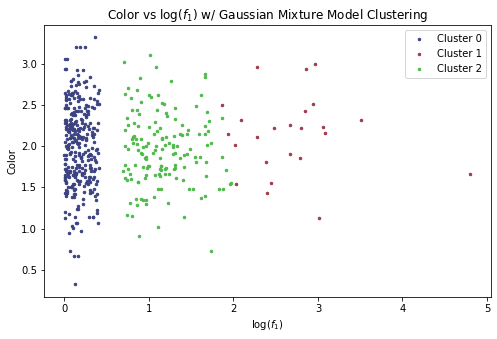

In [82]:
fig,ax = plt.subplots(figsize=(8, 5))
colors = [(0.23, 0.26, 0.5),(0.61,0.23,0.29),(0.3,0.73,0.29)]

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.scatter(cluster_data['log_f1'], cluster_data['color'], color=colors[k], marker=".", s=25, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.ylabel('Color')
plt.legend()
plt.title('Color vs log($f_1$) w/ Gaussian Mixture Model Clustering')
plt.show()

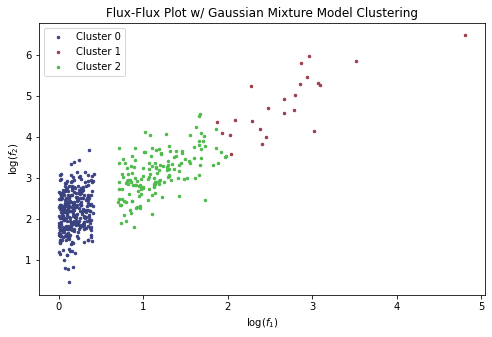

In [83]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.scatter(cluster_data['log_f1'], cluster_data['log_f2'], color=colors[k], marker=".", s=25, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.ylabel('log($f_2$)')
plt.legend()
plt.title('Flux-Flux Plot w/ Gaussian Mixture Model Clustering')
plt.show()

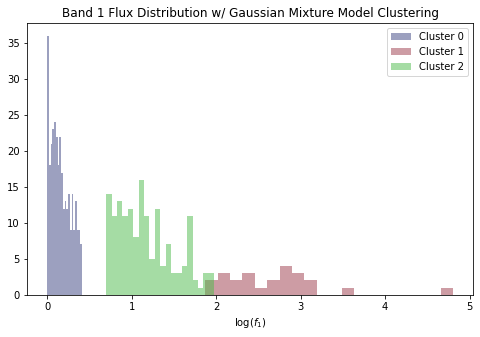

In [84]:
fig,ax = plt.subplots(figsize=(8, 5))
colors = [(0.23, 0.26, 0.5),(0.61,0.23,0.29),(0.3,0.73,0.29)]

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f1'], bins=20,color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.legend()

plt.title('Band 1 Flux Distribution w/ Gaussian Mixture Model Clustering')
plt.show()

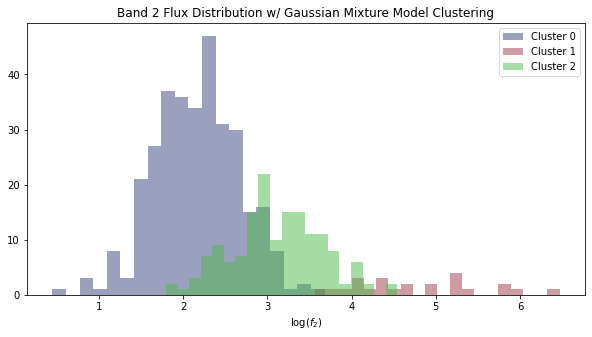

In [85]:
fig,ax = plt.subplots(figsize=(10, 5))
colors = [(0.23, 0.26, 0.5),(0.61,0.23,0.29),(0.3,0.73,0.29)]

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f2'],bins=20, color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_2$)')
plt.legend()
plt.title('Band 2 Flux Distribution w/ Gaussian Mixture Model Clustering')
plt.show()

In [86]:
df.label.value_counts()

0    322
2    154
1     24
Name: label, dtype: int64

## KMeans Clustering

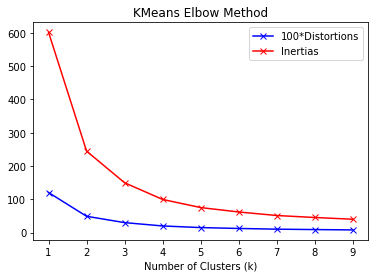

In [109]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
tempData = df[['log_f1','log_f2']]
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tempData)
    
    distortions.append(sum(np.min(cdist(tempData, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / tempData.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]


plt.plot(K, 100*np.array(distortions), 'bx-',label='100*Distortions')
plt.plot(K, inertias, 'rx-',label='Inertias')
plt.legend()
plt.xlabel('Number of Clusters (k)')
plt.title('KMeans Elbow Method')
plt.show()


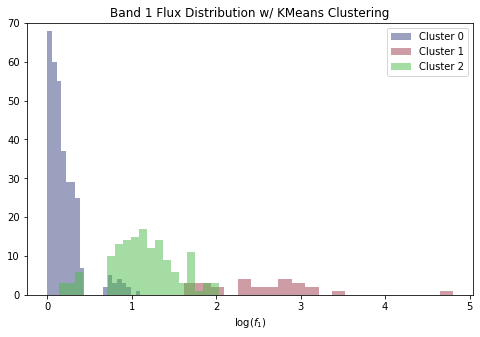

In [110]:
tempData = df[['log_f1','log_f2']]
kmeans = KMeans(n_clusters=3).fit(tempData)

df['label'] = kmeans.labels_


fig,ax = plt.subplots(figsize=(8, 5))
colors = [(0.23, 0.26, 0.5),(0.61,0.23,0.29),(0.3,0.73,0.29)]

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f1'], bins=20,color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.legend()
plt.ylim(0,70)
plt.title('Band 1 Flux Distribution w/ KMeans Clustering')
plt.show()

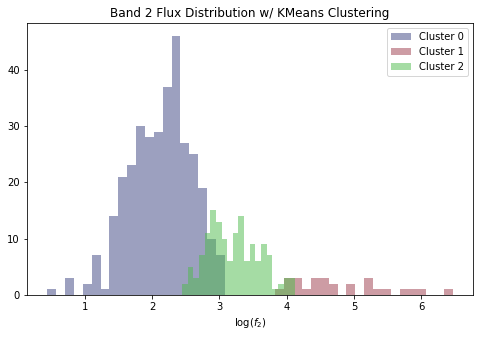

In [111]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.hist(cluster_data['log_f2'],bins=20, color=colors[k], alpha=0.5, label=f'Cluster {k}')

plt.xlabel('log($f_2$)')
plt.legend()
plt.title('Band 2 Flux Distribution w/ KMeans Clustering')
plt.show()

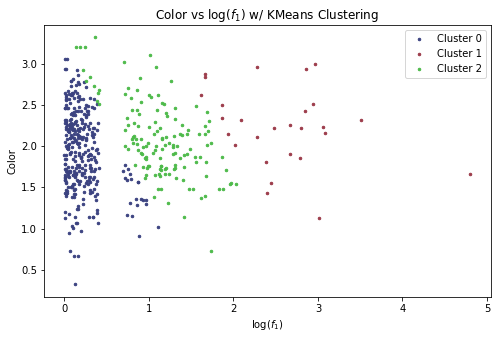

In [112]:
fig,ax = plt.subplots(figsize=(8, 5))

for k, col in enumerate(colors):
    cluster_data = df.loc[df['label'] == k]
    plt.scatter(cluster_data['log_f1'], cluster_data['color'], color=colors[k], marker=".", s=25, label=f'Cluster {k}')

plt.xlabel('log($f_1$)')
plt.ylabel('Color')
plt.legend()
plt.title('Color vs log($f_1$) w/ KMeans Clustering')
plt.show()

In [113]:
df.label.value_counts()

0    330
2    143
1     27
Name: label, dtype: int64